Cortus Un-Supervised Model Investigation
------------------------------------------------------------------------------------------------------------------
### Introduction
------------------------------------------------------------------------------------------------------------------
Author: Joshua Keegan
Process Memory unsupervised learning model to help determine points of interest 

------------------------------------------------------------------------------------------------------------------

In [1]:
import json
import numpy
import os
import pandas as pd
import sys
import sklearn

print(sklearn.__version__)
numpy.set_printoptions(threshold=sys.maxsize)

1.0.2


In [2]:
dataset = pd.read_csv('./Data/compiledCSV/datasetFinal-1.csv', sep=',', low_memory=False, index_col=[0])

# Cleaning the file
# Drop anything containing "memory_section_" as they are present in all dumps
# Also drop useless index column and replace nans with '-1'
dataset = dataset.fillna(0)
dataset = dataset.drop(['processName', 'baddr', 'bintype', 'class', 'dbg_file', 'compiled', 'compiler', 'file', 'humansz'], axis=1)

dataset

,processType,arch,binsz,bits,canary,retguard,crypto,endian,flags,havecode,...,C:\Windows\SysWOW64\cscript.exe_perms,C:\Windows\SysWOW64\linkinfo.dll_perms,C:\Windows\SysWOW64\ntshrui.dll_perms,C:\Windows\SysWOW64\cscapi.dll_perms,C:\Windows\SysWOW64\slc.dll_perms,count_ Console Based Script Host,count_pMicrosoft (R) Windows Script Host Version %1!u!.%2!u!\nCopyright (C) Microsoft Corporation. All rights reserved.\n,"count_\rCScript Error\vInput ErrormThis Unicode version of CScript will only execute under Windows NT.\n\nPlease use the ANSI version of CScript.""$%1!ls!(%2!u!, %3!u!) %4!ls!: %5!ls!\n","count_Usage: CScript scriptname.extension [option...] [arguments...]\n\nOptions:\n //B Batch mode: Suppresses script errors and prompts from displaying\n //D Enable Active Debugging\n //E:engine Use engine for executing script\n //H:CScript Changes the default script host to CScript.exe\n //H:WScript Changes the default script host to WScript.exe (default)\n //I Interactive mode (default, opposite of //B)\n //Job:xxxx Execute a WSF job\n //Logo Display logo (default)\n //Nologo Prevent logo display: No banner will be shown at execution time\n //S Save current command line options for this user\n //T:nn Time out in seconds: Maximum time a script is permitted to run\n //X Execute script in debugger\n //U Use Unicode for redirected I/O from the console","count_Usage: CScript scriptname.extension [option...] [arguments...]\n\nOptions:\n //B Batch mode: Suppresses script errors and prompts from displaying\n //D Enable Active Debugging\n //E:engine Use engine for executing script\n //H:CScript Changes the default script host to CScript.exe\n //H:WScript Changes the default script host to WScript.exe (default)\n //I Interactive mode (default, opposite of //B)\n //Job:xxxx Execute a WSF job\n //Logo Display logo (default)\n //Nologo Prevent logo display: No banner will be shown at execution time\n //S Save current command line options for this user\n //T:nn Time out in seconds: Maximum time a script is permitted to run\n //X Execute script in debugger\n"
0,benign,x86,236338886,64,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,malicious,x86,25153704,32,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,benign,x86,22073862,64,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,benign,x86,29220314,64,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
4,malicious,x86,43370265,32,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,benign,x86,243236299,64,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
553,benign,x86,13630366,64,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
554,benign,x86,12991481,64,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
555,benign,x86,12196647,64,False,False,False,little,0x00061826,True,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Find counts of level of permissions
dataset[dataset.filter(regex='_perms').columns] = dataset[dataset.filter(regex='_perms').columns].apply(lambda col:(pd.Categorical(col).codes))
dataset = pd.concat([dataset, pd.DataFrame(dataset[dataset.filter(regex='_perms').columns].stack().groupby(level=0).value_counts().unstack(fill_value=0).add_prefix("permissionCount_"))], axis=1)
dataset = dataset.drop(dataset.filter(regex='_perms').columns, axis=1)

# Grab count of interesting memory sections per process dump
dataset = dataset.drop(dataset.filter(regex='Memory_Section').columns, axis=1)
dataUniqueMemorySectionCount = dataset[dataset.filter(regex='_size').columns].gt(0).sum(axis=1)
dataset['uniqueMemorySectionCount'] = dataUniqueMemorySectionCount
dataset = dataset.drop(dataset.filter(regex='_size').columns, axis=1)

# Clean up string data into categorical data
dataset['processType'] = pd.Categorical(dataset['processType']).codes
dataset['arch'] = pd.Categorical(dataset['arch']).codes
dataset['bits'] = pd.Categorical(dataset['bits']).codes
dataset['canary'] = pd.Categorical(dataset['canary']).codes
dataset['retguard'] = pd.Categorical(dataset['retguard']).codes
dataset['crypto'] = pd.Categorical(dataset['crypto']).codes
dataset['endian'] = pd.Categorical(dataset['endian']).codes
dataset['flags'] = pd.Categorical(dataset['flags']).codes
dataset['havecode'] = pd.Categorical(dataset['havecode']).codes
dataset['machine'] = pd.Categorical(dataset['machine']).codes
dataset['static'] = pd.Categorical(dataset['static']).codes

dataset_true_labels = dataset['processType']
dataset = dataset.drop('processType', 1)

dataset = dataset[[c for c
            in list(dataset)
            if len(dataset[c].unique()) > 1]]

dataset = dataset.loc[(dataset.sum(axis=1) != 0), (dataset.sum(axis=0) != 0)]
dataset = dataset.loc[(dataset.sum(axis=1) != 1), (dataset.sum(axis=0) != 1)]
dataset = dataset.loc[(dataset.sum(axis=1) != 557), (dataset.sum(axis=0) != 557)]


non_floats = []
for col in dataset:
    if dataset[col].dtypes == "float64" or dataset[col].dtypes == "int64" or dataset[col].dtypes == "int" or dataset[col].dtypes == "float" or dataset[col].dtypes == "int8":
        non_floats.append(col)
    # else:
    #     print("{} datatype is {}".format(col, dataset[col].dtypes))
    
dataset = dataset[non_floats]
# dataset_true_labels = dataset['processType']
print(dataset)

/tmp/ipykernel_96272/2220754689.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop('processType', 1)
/tmp/ipykernel_96272/2220754689.py:32: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset = dataset.loc[(dataset.sum(axis=1) != 0), (dataset.sum(axis=0) != 0)]
/tmp/ipykernel_96272/2220754689.py:33: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataset = dataset.loc[(dataset.sum(axis=1) != 1), (dataset.sum(axis=0) != 1)]
/tmp/ipykernel_96272/2220754689.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeri

         binsz  bits  machine  static  streams       size           rip  \
0    236338886     1        0       0       14  236338886  4.288723e+09   
1     25153704     0        1       0       13   25153704  0.000000e+00   
2     22073862     1        0       0       14   22073862  5.365450e+09   
3     29220314     1        0       0       13   29220314  5.357191e+09   
4     43370265     0        1       0       13   43370265  0.000000e+00   
..         ...   ...      ...     ...      ...        ...           ...   
552  243236299     1        0       0       15  243236299  5.367023e+09   
553   13630366     1        0       0       13   13630366  5.357638e+09   
554   12991481     1        0       0       13   12991481  5.366551e+09   
555   12196647     1        0       0       13   12196647  5.365241e+09   
556   20441804     0        1       0       13   20441804  0.000000e+00   

     format.1  imports  registers  ...  \
0          13    40533         18  ...   
1          12  

0
1
0
0
1
0
1
1
0
1
0
1
1
0
0
0
1
0
1
0
1
1
0
0
1
0
0
1
0
0
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
1
0
1
1
1
0
0
1
0
1
0
0
0
1
1
0
1
0
1
0
1
0
1
0
0
0
1
1
1
1
0
0
1
1
1
1
0
1
1
1
1
1
0
0
0
0
0
1
1
0
0
0
1
1
0
0
0
0
0
0
0
1
1
0
0
1
0
0
0
1
1
0
0
0
1
1
0
0
1
0
0
1
1
1
1
0
0
0
1
0
1
1
0
0
1
1
0
0
1
0
1
1
0
1
1
1
0
1
0
1
0
1
1
1
0
0
0
1
1
1
1
1
0
1
0
0
0
1
1
1
0
1
1
1
0
0
0
1
0
0
1
0
0
0
0
1
1
0
1
0
0
0
1
1
0
0
1
1
0
0
1
0
0
1
1
0
0
1
1
0
0
0
0
1
1
0
1
0
1
1
0
0
0
1
0
0
0
1
1
0
1
0
1
0
1
0
1
1
0
1
0
0
0
0
0
0
1
1
1
1
1
0
1
0
0
0
0
0
0
1
0
0
1
1
0
0
0
1
1
0
0
0
1
1
0
1
0
1
1
0
1
1
0
0
0
1
0
0
1
0
0
1
0
1
1
1
1
1
1
1
1
0
0
1
0
1
1
0
1
1
0
0
0
0
1
0
0
0
0
0
1
1
0
0
0
1
0
1
0
0
1
1
0
0
1
1
0
0
0
1
1
0
1
1
1
0
1
0
0
1
1
1
1
1
0
1
1
1
0
1
1
0
1
1
1
0
1
0
1
1
1
1
1
0
0
1
0
0
0
0
1
1
1
1
0
1
0
1
0
1
1
1
0
1
1
1
0
0
1
1
0
0
0
0
0
1
1
1
1
1
1
0
0
1
0
1
0
1
1
0
1
0
0
0
0
1
0
0
1
0
0
0
1
1
0
1
1
0
1
1
0
1
1
0
0
0
1
1
0
1
0
1
0
0
1
0
1
0
0
0
1
0
0
1
1
0
0
1
0
1
1
0
0
1
0
1
1
1
0
0
1
0
0
0
0
0
1
0
0
0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


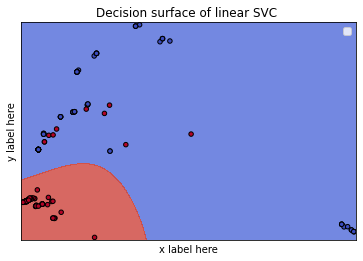

In [4]:
# k-means clustering
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import svm

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

for i in dataset_true_labels:
    print(i)
# print(dataset_true_labels)


X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_true_labels, test_size=0.3,random_state=109) # 70% training and 30% test


preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

clusterer = Pipeline(
   [
       (
           "kmeans",
           svm.SVC(kernel='rbf')
           # KMeans(
           #     n_clusters=2,
           #     init="k-means++",
           #     n_init=5,
           #     max_iter=5000,
           #     random_state=42,
           #     algorithm='full',
           #     tol=1
           # ),
       ),
   ]
)

pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(dataset_true_labels)
pipe.fit(X_train, y_train)

preprocessed_data = pipe["preprocessor"].transform(X_test)
predicted_labels = pipe["clusterer"]["kmeans"].predict(preprocessed_data)

print("Accuracy:", accuracy_score(y_test, predicted_labels))

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = preprocessed_data[:, 0], preprocessed_data[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, pipe["clusterer"]["kmeans"], xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()
